In [1]:
import torch
import os
import numpy as np
import cv2
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from itertools import islice
from collections import Counter

## Data

In [2]:
img_folder = './data/fire/train/images'
label_folder = './data/fire/train/labels'
out_img_folder = './data/fire/train_resized/images'
out_label_folder = './data/fire/train_resized/labels'
os.makedirs(out_img_folder, exist_ok=True)
os.makedirs(out_label_folder, exist_ok=True)
new_size=448

In [ ]:
def resized_dataset (img_folder, label_folder, out_img_folder, out_label_folder, new_size):
    for fname in os.listdir(img_folder):
        if not fname.endswith(('.jpg')): continue

        img = cv2.imread(os.path.join(img_folder, fname))
        img_path_out = os.path.join(out_img_folder, fname)

        txt = os.path.splitext(fname)[0] + '.txt'
        lb_path_in = os.path.join(label_folder, txt)
        lb_path_out = os.path.join(out_label_folder, txt)

        resized = cv2.resize(img, (new_size, new_size))
        cv2.imwrite(img_path_out, resized)
        
        with open(lb_path_in, 'r') as f_in, open(lb_path_out, 'w') as f_out:
            for line in f_in:
                values = line.strip().split()
                f_out.write(f"{values[0]} {values[1]} {values[2]} {values[3]} {values[4]}\n")

resized_dataset (img_folder, label_folder, out_img_folder, out_label_folder, new_size)

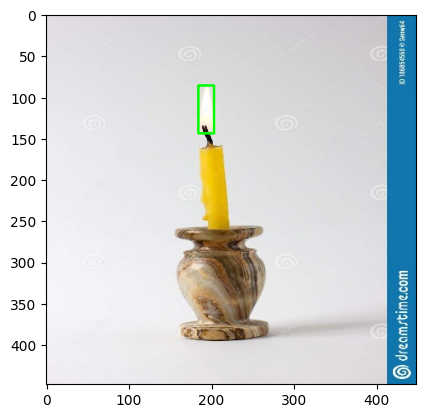

In [5]:
img = cv2.imread('./data/fire/train_resized/images/-186854560_jpg.rf.0e7ab19a7ef2b2b138eb9e8fbd39e1b3.jpg')
label = './data/fire/train_resized/labels/-186854560_jpg.rf.0e7ab19a7ef2b2b138eb9e8fbd39e1b3.txt'
with open(label, 'r') as f:
    h, w = img.shape[:2]
    for line in f:
        values = line.strip().split()
        cls_id = values[0]
        x = float(values[1]) * w
        y = float(values[2]) * h
        w_bb = float(values[3]) * w
        h_bb = float(values[4]) * h
        img = cv2.rectangle(img, (int(x - w_bb/2), int(y - h_bb/2)), (int(x + w_bb/2), int(y + h_bb/2)), color=(0, 255, 0), thickness=2)

plt.imshow(img[:,:,::-1])

## Model

In [ ]:
backbone = models.vgg16(pretrained=True) # input: (Batch, 448, 448, 3)
backbone = torch.nn.Sequential(*list(backbone.children())[:-2]) # Output: (Batch, 512, 14, 14)

In [ ]:
class YOLOv1(torch.nn.Module):
    def __init__ (self, backbone):
        super.__init__()
        self.backbone = backbone # sequential

        # head
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, kernel_size=3, padding=1), # mở rộng đặc trưng
            torch.nn.LeakyReLU(0.1),
            torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=1), # đi sâu hơn vào đặc trưng
            torch.nn.LeakyReLU(0.1)
        )

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(1024 * 14 * 14, 4096), # kích thước feature map 14*14
            torch.nn.Dropout(0.5),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(4096, 7 * 7 * 12) # lưới 7*7*(2 lớp + 5 tham số * 2 boxes)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.view(-1, 7, 7, 12)

## Loss

In [3]:
def compute_iou(box1, box2):
    # box1: Tensor shape (N, 4), N là số lượng ô có object
    # box format: (xc, yc, w, h)
    box1_xy1 = box1[..., :2] - box1[..., 2:] / 2
    box1_xy2 = box1[..., :2] + box1[..., 2:] / 2
    box2_xy1 = box2[..., :2] - box2[..., 2:] / 2
    box2_xy2 = box2[..., :2] + box2[..., 2:] / 2

    # Intersection
    inter_xy1 = torch.max(box1_xy1, box2_xy1)
    inter_xy2 = torch.min(box1_xy2, box2_xy2)
    inter_wh = (inter_xy2 - inter_xy1).clamp(min=0)
    inter_area = inter_wh[..., 0] * inter_wh[..., 1]

    # Area
    box1_area = (box1_xy2[..., 0] - box1_xy1[..., 0]) * (box1_xy2[..., 1] - box1_xy1[..., 1])
    box2_area = (box2_xy2[..., 0] - box2_xy1[..., 0]) * (box2_xy2[..., 1] - box2_xy1[..., 1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / (union_area + 1e-6)


In [ ]:
def yolo_loss(preds, targets, lambda_coord=5, lambda_noobj=0.5):
    """
    Hàm loss cho YOLOv1
    Đầu vào:
        predictions (Tensor): Shape (batch, 7, 7, 12) - Dự đoán của mô hình
        targets (Tensor): Shape (batch, 7, 7, 12) - Ground truth
        lambda_coord (float): Trọng số cho localization loss (tọa độ và kích thước có độ quan trọng lớn hơn)
        lambda_noobj (float): Trọng số cho confidence loss của box không có vật thể
    Đầu ra:
        total_loss (Tensor): Tổng loss
    """

    batch_size = preds.size[0]
    S = 7 # lưới
    B = preds.size[3] # anchor boxes mỗi cell

    pred_boxes = preds[..., :10].view(batch_size, S, S, B, 5) # (x, y, w, h, conf) * 2
    target_boxes = targets[..., :10].view(batch_size, S, S, B, 5)
    pred_classes = preds[..., 10:]
    target_classes = targets[..., 10:]

    # đánh dấu ô lưới chứa đối tượng
    obj_mask = target_boxes[..., 0, 4] > 0
    noobj_mask = ~obj_mask

    # gán trách nhiệm box cho ô chứa đối tượng dự đoán box nào có giá trị iou tốt nhất
    pred_box0 = pred_boxes[..., 0, :4][obj_mask]
    pred_box1 = pred_boxes[..., 1, :4][obj_mask]
    target_box = target_boxes[..., 0, :4][obj_mask]
    iou0 = compute_iou(pred_box0, target_box)
    iou1 = compute_iou(pred_box1, target_box)

    responsible_mask = iou0 > iou1

    pred_box = torch.where(
            responsible_mask.unsqueeze(-1),
            pred_box0,
            pred_box1
        )
    
    # 1. localization loss
    coord_loss = 0
    if obj_mask.sum() > 0:
        # sai số tọa độ
        xy_loss = F.mse_loss(pred_box[..., 0:2], target_box[..., 0:2], reduction='sum')

        # sai số kích thước
        pred_wh = torch.sqrt(pred_box[..., 2:4].clamp(min=0))
        target_wh = torch.sqrt(target_box[..., 2:4])
        wh_loss = F.mse_loss(pred_wh, target_wh, reduction='sum')

        coord_loss = lambda_coord * (xy_loss + wh_loss)

    # 2. confidence loss
    # box chứa vật thể
    conf_obj_loss = 0
    if obj_mask.sum() > 0:
        pred_conf_obj = pred_box[..., 4]
        target_conf_obj = target_box[..., 4][obj_mask]
        conf_obj_loss = F.mse_loss(pred_conf_obj, target_conf_obj, reduction='sum')

    # box không chứa vật thể (tất cả box) 
    pred_conf_noobj = pred_boxes[..., :, 4][noobj_mask.unsqueeze(-1).expand(-1, -1, -1, B)].view(-1)
    target_conf_noobj = target_boxes[..., :, 4][noobj_mask.unsqueeze(-1).expand(-1, -1, -1, B)].view(-1)
    conf_noobj_loss = lambda_noobj * F.mse_loss(pred_conf_noobj, target_conf_noobj, reduction='sum')

    confidence_loss = conf_obj_loss + conf_noobj_loss

    # 3. class loss
    class_loss = 0
    if obj_mask.sum() > 0:
        pred_class = pred_classes[obj_mask]
        target_class = target_classes[obj_mask]
        class_loss = F.mse_loss(pred_class, target_class, reduction='sum')

    # tổng loss
    total_loss = coord_loss + confidence_loss + class_loss
    total_loss /= batch_size  # Chuẩn hóa theo batch size

    return total_loss

## Train

In [11]:
device = torch.device("cuda")
print(torch.cuda.is_available())
print(device)

True
cuda


In [ ]:
model = YOLOv1(backbone)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epoch_losses = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = yolo_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(dataloader)
    epoch_losses.append(average_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")

In [ ]:
torch.save(model.state_dict(), 'yolov1.pth')

## Test
